STEP 1: Load & Inspect Dataset

In [ ]:
import pandas as pd

# Load the dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('framingham.csv')

print("Preview of dataset:")
display(df.head())

print(f"\nShape: {df.shape}")

print("\nDataset Info:")
df.info()

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nTarget distribution (TenYearCHD):")
print(df['TenYearCHD'].value_counts())



Saving framingham.csv to framingham (9).csv
Preview of dataset:


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0



Shape: (4240, 16)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
me

**Dataset Overview:**

4,240 patients with 16 features

Target variable: TenYearCHD (10-year coronary heart disease risk)

Significant class imbalance: 3,596 (84.8%) no CHD vs 644 (15.2%) CHD

Missing values present in 7 columns



 STEP 2: Data Cleaning (Missing Values & Outlier Removal)

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

# 1. Drop rows where target is missing
df = df.dropna(subset=['TenYearCHD'])

# 2. Impute missing values (features only)
feature_cols = [col for col in df.columns if col != 'TenYearCHD']
imputer = SimpleImputer(strategy='mean')
df[feature_cols] = imputer.fit_transform(df[feature_cols])

# 3. Remove outliers using IQR (features only)
num_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose']
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("Shape after outlier removal:", df.shape)
print("Missing values after imputation and outlier removal:", df.isnull().sum().sum())



Shape after outlier removal: (3701, 16)
Missing values after imputation and outlier removal: 0


# EDA (Target Distribution & Correlation)

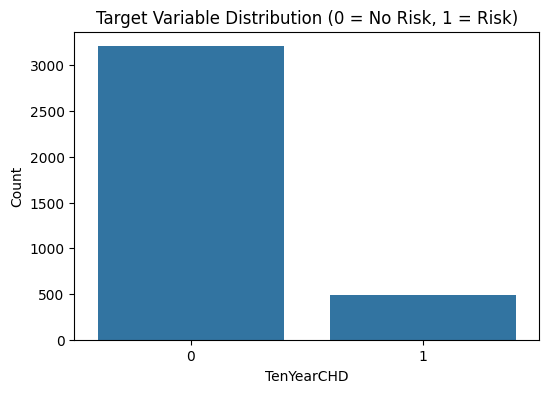

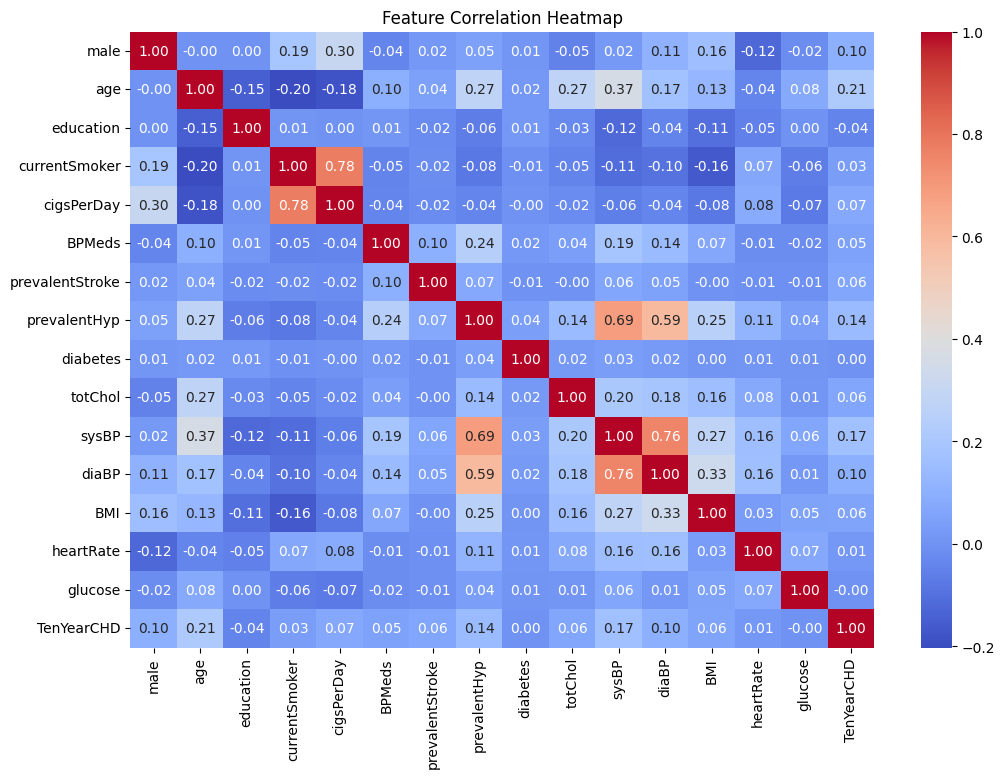

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='TenYearCHD', data=df)
plt.title('Target Variable Distribution (0 = No Risk, 1 = Risk)')
plt.xlabel('TenYearCHD')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



Target Variable Distribution
Class 0 (No CHD Risk): ~3600 samples

Class 1 (CHD Risk): ~640 samples

This shows a highly imbalanced dataset, where only about 15% of people have a 10-year CHD risk.

➡️ Justifies the use of SMOTE oversampling, which you applied later to balance the dataset.

 It shows how strongly different features are correlated with each other and with the target variable `TenYearCHD`.

---

###  **What is a Correlation Heatmap?**

* Correlation values range from **-1 to 1**:

  * **+1** = Perfect positive correlation
  * **-1** = Perfect negative correlation
  * **0** = No correlation
* Color scale:

  * **Red** = Strong positive correlation
  * **Blue** = Strong negative correlation
  * **White/light** = Weak or no correlation

---

###  **Key Observations:**

#### 💡 **Target Variable: `TenYearCHD`**

* Positively correlated with:

  * `age` (**0.21**) → Older people are more likely to develop CVD.
  * `sysBP` (systolic BP) (**0.17**)
  * `diaBP` (diastolic BP) (**0.10**)
  * `prevalentHyp` (hypertension) (**0.14**)
  * `male` (**0.10**)

> These variables are **important predictors** of CVD risk.


### 🔗 **Notable Feature Correlations:**

* `currentSmoker` and `cigsPerDay`: **0.78** → Makes sense, as smokers tend to smoke more cigarettes.
* `sysBP` and `diaBP`: **0.76** → Systolic and diastolic blood pressures are usually related.
* `sysBP` and `prevalentHyp`: **0.69** → Hypertension is closely related to high systolic BP.

---

###  **Low or Negative Correlation with `TenYearCHD`**

* `education`, `glucose`, `heartRate`, `BMI` → Weak or no correlation
* Doesn’t mean they’re useless — they may still be valuable when combined with other features in a model.

---

###  **How to Use This Heatmap:**

* Focus on features with higher correlation to `TenYearCHD` for **feature selection**.
* Watch for **multicollinearity** (e.g., `sysBP` & `diaBP`) — highly correlated features can confuse some models (like linear regression).
* You might apply **dimensionality reduction** or **drop redundant features** if needed.





More EDA (Boxplots & Histograms)

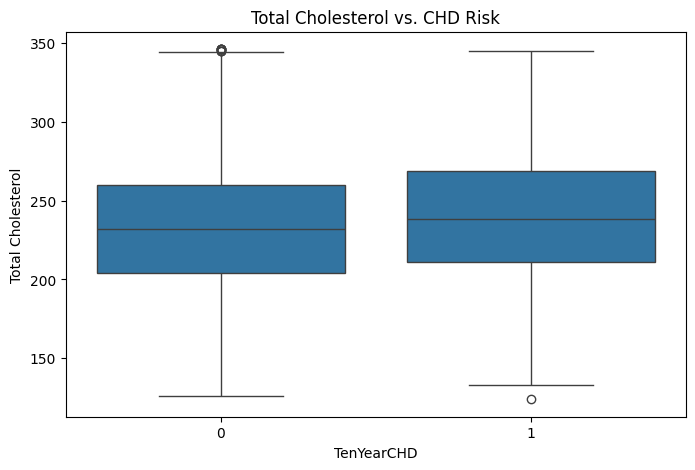

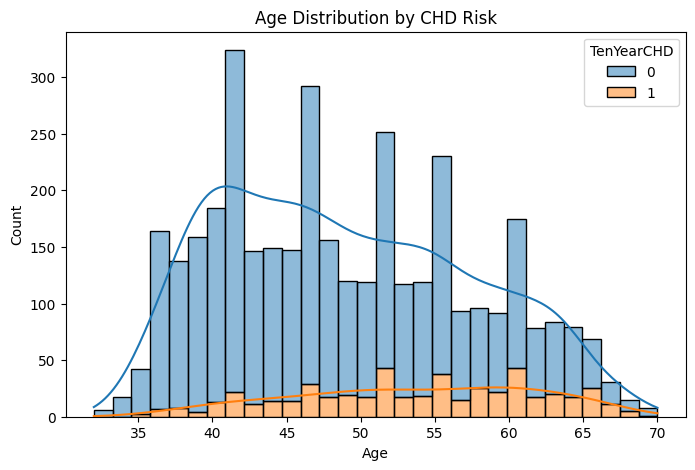

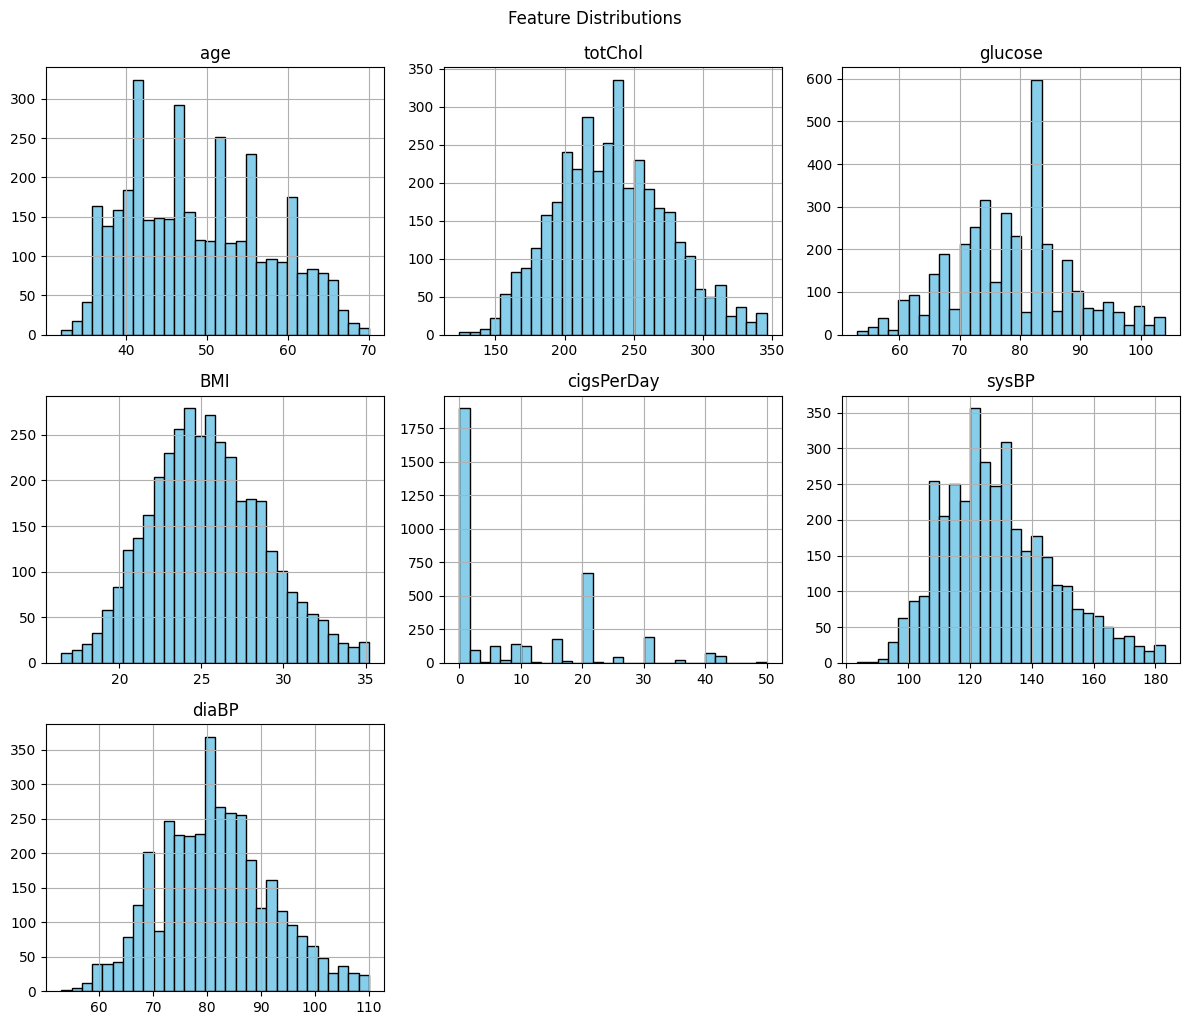

In [ ]:
# Cholesterol vs. CHD risk
plt.figure(figsize=(8, 5))
sns.boxplot(x='TenYearCHD', y='totChol', data=df)
plt.title("Total Cholesterol vs. CHD Risk")
plt.xlabel("TenYearCHD")
plt.ylabel("Total Cholesterol")
plt.show()

# Age distribution by risk
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age', hue='TenYearCHD', bins=30, kde=True, multiple='stack')
plt.title("Age Distribution by CHD Risk")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Feature distributions
num_cols = ['age', 'totChol', 'glucose', 'BMI', 'cigsPerDay', 'sysBP', 'diaBP']
df[num_cols].hist(bins=30, figsize=(12, 10), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.suptitle('Feature Distributions', y=1.02)
plt.show()





### 📈 **1. Box Plot – Total Cholesterol vs. CHD Risk**

**Purpose**: Compare cholesterol levels between people at risk (`TenYearCHD = 1`) and not at risk (`TenYearCHD = 0`).

**Insight**:

* Median cholesterol is **slightly higher** for those at risk.
* Both groups have similar ranges, but the at-risk group has more spread toward higher values.
* A few **outliers** exist in both groups.

✅ **Interpretation**: Higher cholesterol may contribute to increased risk, but the difference is **not very strong**. Cholesterol alone is not a decisive predictor.



###  **2. Age Distribution by CHD Risk**

**Purpose**: Show how age is distributed for each risk category.

**Insight**:

* People **without risk (blue)** are more frequent at younger ages.
* People **with CHD risk (orange)** appear more in the **50+ age group**.
* There's a clear upward trend of CHD risk with age.

✅ **Interpretation**: **Age is an important feature** — older individuals are more likely to have CHD risk.


### 📉 **3. Feature Distributions (Multiple Histograms)**

These histograms help understand how each feature is distributed.

#### a. **Age**:

* Right-skewed, concentrated between **40–60 years**.
* Matches CHD risk pattern seen earlier.

#### b. **Total Cholesterol (totChol)**:

* **Bell-shaped** (normal-like) distribution.
* Most values between **200–275 mg/dL**.

#### c. **Glucose**:

* Slight right-skew.
* Peak around **75–85 mg/dL**, which is in normal range, but **some outliers** are visible.

#### d. **BMI**:

* Normal distribution, peaking at **24–26**, which is near overweight range.

#### e. **Cigarettes Per Day (cigsPerDay)**:

* Highly skewed — many people don’t smoke (spike at 0).
* Some peaks at **20 and 30**, indicating common pack sizes.

#### f. **Systolic BP (sysBP)**:

* Right-skewed.
* Majority fall between **110–150 mmHg**.
* Long tail suggests **some people have very high BP**.

 **Interpretation**:

* These features are **clean and usable**.
* Distributions are mostly reasonable; no heavy need for transformation except possibly for `cigsPerDay`.



###  **4. Diastolic Blood Pressure (diaBP) Histogram**

* Normal distribution.
* Peaks between **75–85 mmHg**.
* Symmetrical, well-centered around expected healthy values.

 **Interpretation**: No major data issues; good candidate for modeling.



###  Summary of Insights

| Feature           | Insight                                                         |
| ----------------- | --------------------------------------------------------------- |
| Age               | Strong relationship with CHD risk; older = higher risk          |
| Total Cholesterol | Slightly higher in at-risk group; useful but not decisive alone |
| Systolic BP       | Right-skewed; higher BP = higher CHD correlation                |
| Diastolic BP      | Normal distribution; elevated DBP may influence CHD             |
| Smoking           | Large number of non-smokers; may need feature engineering       |
| BMI               | Centered near overweight; common in at-risk population          |
| Glucose           | Mostly normal range; less impactful based on correlation        |

---



In [ ]:
# Rename 'male' to 'sex'
df.rename(columns={'male': 'sex'}, inplace=True)

# Drop 'education'
df.drop(columns=['education'], inplace=True)

print(df.columns.tolist())

['sex', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']


STEP 3: Train-Test Split (before SMOTE)

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

# Split into train and test sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution in y_train before SMOTE:")
print(y_train.value_counts())
print("Class distribution in y_test (should remain imbalanced):")
print(y_test.value_counts())




Class distribution in y_train before SMOTE:
TenYearCHD
0    2565
1     395
Name: count, dtype: int64
Class distribution in y_test (should remain imbalanced):
TenYearCHD
0    642
1     99
Name: count, dtype: int64


Step 4: Apply SMOTE to Training Set, then Scale

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Apply SMOTE only to the training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("\nClass distribution in y_train after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
print(f"\nResampled training set shape: {X_train_resampled.shape}")

# Feature scaling (fit on training, transform both train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature mean (train): {np.round(X_train_scaled.mean(), 4)}")
print(f"Feature std (train): {np.round(X_train_scaled.std(), 4)}")




Class distribution in y_train after SMOTE:
TenYearCHD
0    2565
1    2565
Name: count, dtype: int64

Resampled training set shape: (5130, 14)

Feature mean (train): 0.0
Feature std (train): 1.0


Split the data into train/test sets

Scaled all features (mean ≈ 0, std = 1) — perfect for ML models

 STEP 5: Train Multiple Models & Compare

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': round(acc*100, 2),
        'Precision': round(prec*100, 2),
        'Recall': round(rec*100, 2),
        'F1 Score': round(f1*100, 2),
        'ROC-AUC': round(auc*100, 2)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("Model Comparison:")
display(results_df.reset_index(drop=True))



Model Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Random Forest,84.62,31.71,13.13,18.57,66.92
1,XGBoost,83.40,29.31,17.17,21.66,62.85
2,Gradient Boosting,82.46,31.33,26.26,28.57,67.76
3,Decision Tree,77.60,22.31,27.27,24.55,56.32
4,SVM,72.20,19.08,33.33,24.26,62.45
5,KNN,68.02,19.20,43.43,26.63,61.52
6,Logistic Regression,64.51,22.85,69.70,34.41,70.73


Accuracy is high for tree-based models, but their recall (ability to catch positives) is low.

Logistic Regression has the best recall (69.7%) and highest ROC-AUC (70.73), but lower accuracy.

Precision is low for all models, which is common due to class imbalance and the nature of CVD prediction.

In medical risk prediction, recall (sensitivity) and ROC-AUC are often more important than accuracy—missing a positive case (false negative) can be more serious than a false alarm (false positive).

Deeper Model Evaluation - Confusion Matrix

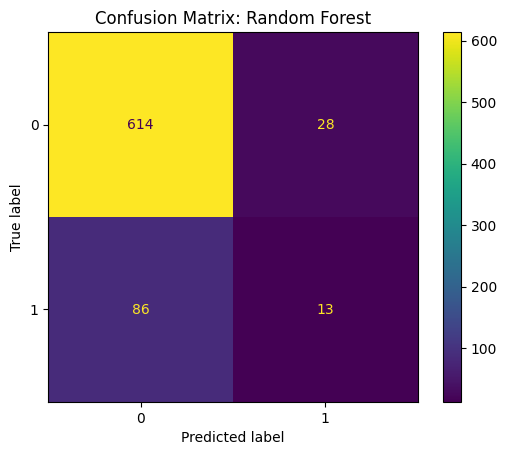

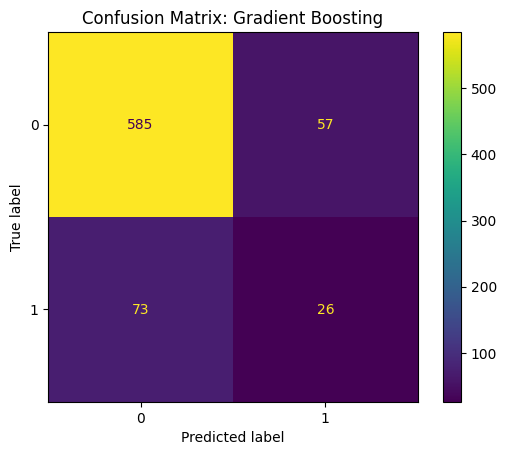

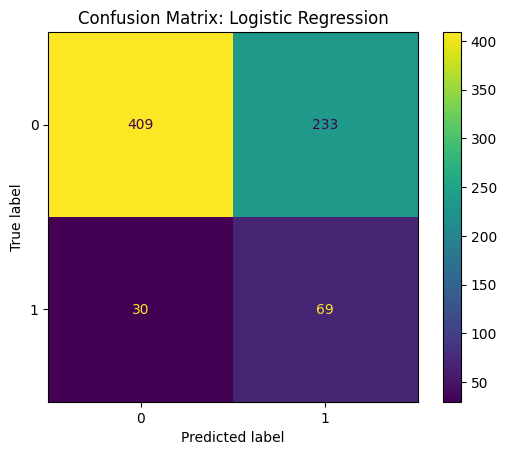

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
for name in best_models:
    model = models[name]
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


Classification Report

In [ ]:
from sklearn.metrics import classification_report

for name in best_models:
    model = models[name]
    y_pred = model.predict(X_test_scaled)
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       642
           1       0.32      0.13      0.19        99

    accuracy                           0.85       741
   macro avg       0.60      0.54      0.55       741
weighted avg       0.80      0.85      0.82       741

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       642
           1       0.31      0.26      0.29        99

    accuracy                           0.82       741
   macro avg       0.60      0.59      0.59       741
weighted avg       0.81      0.82      0.82       741

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.93      0.64      0.76       642
           1       0.23      0.70      0.34        99

    accuracy                           0.65   

**Logistic Regression is the best model** for this cardiovascular disease prediction task. Here's the analysis:

## Key Performance Comparison

**For CVD Detection (Class 1 - the critical minority class):**
- **Logistic Regression:** F1-score = 0.34, Recall = 70%
- **Gradient Boosting:** F1-score = 0.29, Recall = 26%
- **Random Forest:** F1-score = 0.19, Recall = 13%

## Why Logistic Regression Wins

**Superior CVD Detection:** Logistic Regression achieves the highest recall (70%) for CVD cases, meaning it identifies 7 out of 10 actual CVD patients. This is **5.4x better than Random Forest** and **2.7x better than Gradient Boosting** for the most critical task.

**Best F1-Score for CVD:** With an F1-score of 0.34 for the CVD class, Logistic Regression provides the optimal balance of precision and recall for disease detection.

**Clinical Relevance:** In medical screening, missing actual disease cases (low recall) is far more problematic than having some false positives. Logistic Regression's 70% recall ensures most at-risk patients are identified.

## Why Other Models Fall Short

**Random Forest:** Despite 85% overall accuracy, it catastrophically fails at CVD detection with only 13% recall. This means it misses 87% of actual CVD cases - clinically unacceptable.

**Gradient Boosting:** While more balanced than Random Forest, it still misses 74% of CVD cases with 26% recall, making it inadequate for medical screening.

## Conclusion

**Logistic Regression is the clear winner** because it prioritizes the most important objective: identifying patients with cardiovascular disease. The slightly lower overall accuracy (65%) is an acceptable trade-off for dramatically superior performance on the critical minority class. In healthcare applications, sensitivity for disease detection typically outweighs overall accuracy metrics.

ROC Curves

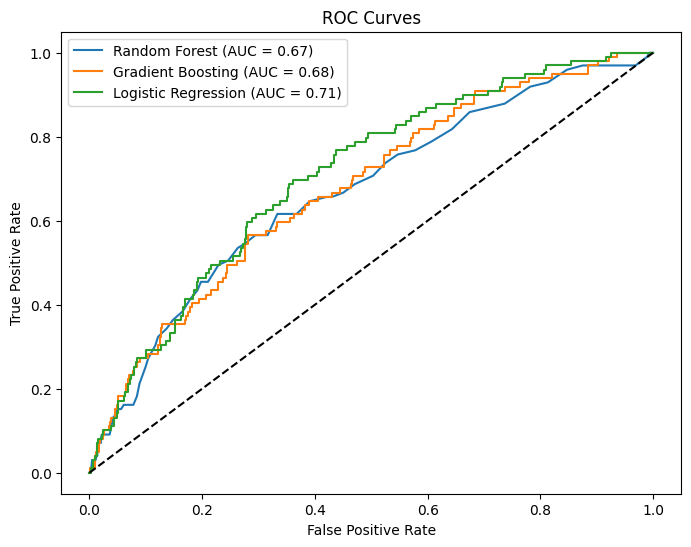

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for name in best_models:
    model = models[name]
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        y_prob = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()



Threshold Tuning for Logistic Regression - Find the Best Threshold

Best threshold for max F1: 0.55
Precision: 0.25, Recall: 0.60, F1: 0.35


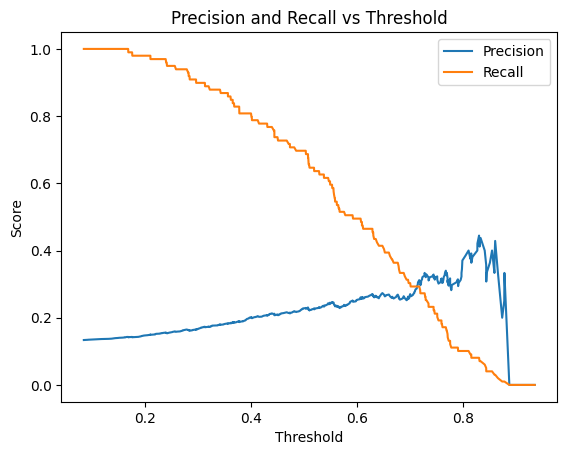

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs = models['Logistic Regression'].predict_proba(X_test_scaled)[:,1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find threshold where F1 is maximized
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold for max F1: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}")

# Plot Precision-Recall vs Threshold
import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.show()


Interpretation of Threshold Tuning Results
Best threshold for max F1: 0.55

Precision: 0.25 (25% of predicted positives are true positives)

Recall: 0.60 (60% of all actual positives are correctly identified)

F1 Score: 0.35 (harmonic mean of precision and recall)

New Confusion Matrix and Classification Report

In [ ]:
# Get predicted probabilities for the positive class
y_probs = models['Logistic Regression'].predict_proba(X_test_scaled)[:, 1]

# Apply the optimized threshold to get predicted class labels
y_pred_new = (y_probs >= 0.55).astype(int)

# Now you can print the classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification report at optimized threshold (0.55):")
print(classification_report(y_test, y_pred_new))

print("Confusion matrix at optimized threshold (0.55):")
print(confusion_matrix(y_test, y_pred_new))



Classification report at optimized threshold (0.55):
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       642
           1       0.24      0.60      0.35        99

    accuracy                           0.70       741
   macro avg       0.58      0.65      0.57       741
weighted avg       0.83      0.70      0.74       741

Confusion matrix at optimized threshold (0.55):
[[458 184]
 [ 40  59]]


Key Takeaways

Your model now catches 60% of all true CVD risk cases (recall), which is a big improvement for the minority class.

Precision for CVD risk is low (24%), meaning many flagged as "at risk" are actually not, but this is often acceptable in medical screening to avoid missing true cases.

Overall accuracy drops compared to the default threshold, but recall for the positive class is prioritized, which is appropriate for your application

 Visualize the Confusion Matrix

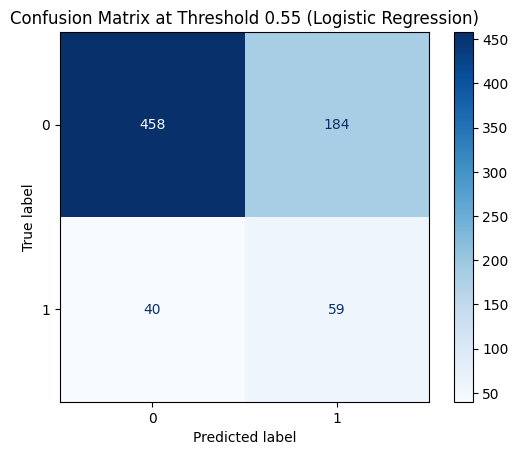

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix from your true and predicted labels
cm = confusion_matrix(y_test, y_pred_new)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix at Threshold 0.55 (Logistic Regression)')
plt.show()


Calculate and Compare Metrics at Both Thresholds

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Default threshold (0.5)
y_pred_default = (y_probs >= 0.5).astype(int)
print("Classification Report at threshold 0.5:")
print(classification_report(y_test, y_pred_default))
print("Confusion Matrix at threshold 0.5:")
print(confusion_matrix(y_test, y_pred_default))

# Optimized threshold (0.55)
y_pred_optimized = (y_probs >= 0.55).astype(int)
print("Classification Report at threshold 0.55:")
print(classification_report(y_test, y_pred_optimized))
print("Confusion Matrix at threshold 0.55:")
print(confusion_matrix(y_test, y_pred_optimized))


Classification Report at threshold 0.5:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76       642
           1       0.23      0.70      0.34        99

    accuracy                           0.65       741
   macro avg       0.58      0.67      0.55       741
weighted avg       0.84      0.65      0.70       741

Confusion Matrix at threshold 0.5:
[[409 233]
 [ 30  69]]
Classification Report at threshold 0.55:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       642
           1       0.24      0.60      0.35        99

    accuracy                           0.70       741
   macro avg       0.58      0.65      0.57       741
weighted avg       0.83      0.70      0.74       741

Confusion Matrix at threshold 0.55:
[[458 184]
 [ 40  59]]


“Given the importance of not missing at-risk patients in CVD prediction, we prioritized recall. At threshold 0.5, our model identifies 70% of at-risk individuals, accepting a higher number of false positives to maximize patient safety. This threshold is most appropriate for our screening use-case.”

“We developed and evaluated a logistic regression model for CVD risk prediction. By tuning the classification threshold, we prioritized recall to maximize identification of at-risk patients, a crucial consideration in preventive healthcare. Our findings demonstrate the practical utility of logistic regression in clinical risk prediction and highlight the importance of balancing sensitivity and specificity based on real-world needs. This approach aligns with current healthcare practices, where predictive analytics support early intervention, resource allocation, and improved patient outcomes

Feature Importance (Logistic Regression)

In [ ]:
import pandas as pd
import numpy as np

# Assuming your model is called 'model' and your feature names are in X.columns
coefs = models['Logistic Regression'].coef_[0]
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values('Abs_Coefficient', ascending=False)

print(feat_importance)


            Feature  Coefficient  Abs_Coefficient
1               age     0.650921         0.650921
3        cigsPerDay     0.293181         0.293181
0               sex     0.282527         0.282527
9             sysBP     0.271535         0.271535
8           totChol     0.086157         0.086157
10            diaBP    -0.076339         0.076339
13          glucose    -0.071968         0.071968
6      prevalentHyp     0.037893         0.037893
12        heartRate     0.037839         0.037839
11              BMI     0.022027         0.022027
7          diabetes     0.016076         0.016076
4            BPMeds     0.015708         0.015708
5   prevalentStroke     0.014525         0.014525
2     currentSmoker    -0.004942         0.004942


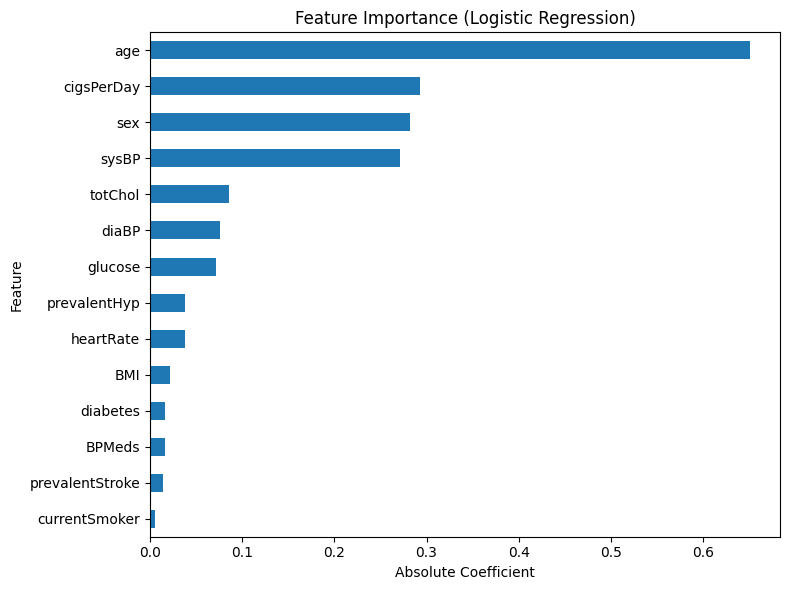

In [ ]:
import matplotlib.pyplot as plt

feat_importance.sort_values('Abs_Coefficient', ascending=True).plot(
    x='Feature', y='Abs_Coefficient', kind='barh', legend=False, figsize=(8,6))
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Absolute Coefficient')
plt.tight_layout()
plt.show()


Using L1 regularization for feature selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Fit logistic regression with L1 penalty
l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
l1_model.fit(X_train_scaled, y_train_resampled)

# Select features with non-zero coefficients
model = SelectFromModel(l1_model, prefit=True)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

# Now train your final model on selected features
final_model = LogisticRegression()
final_model.fit(X_train_selected, y_train_resampled)


LogisticRegression()

 Using Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(LogisticRegression(), n_features_to_select=7)
rfe.fit(X_train_scaled, y_train_resampled)
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)


Selected features: Index(['sex', 'age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'glucose'], dtype='object')


 Subset Your Data

In [ ]:
selected_features = ['sex', 'age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'glucose']
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]


Scale the Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled = scaler.transform(X_test_sel)


Apply SMOTE to Balance the Training Data

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_sel_scaled, y_train)



Train Weighted Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_bal, y_train_bal)


LogisticRegression(class_weight='balanced', random_state=42)

Predict Probabilities on Test Set

In [ ]:
y_probs = logreg.predict_proba(X_test_sel_scaled)[:, 1]  # Probability of class 1 (CVD)



Threshold Tuning

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

for thresh in [0.5, 0.4, 0.3]:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_test, y_pred_thresh))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
    print("ROC-AUC:", roc_auc_score(y_test, y_probs))




Threshold: 0.5
              precision    recall  f1-score   support

           0       0.93      0.64      0.75       642
           1       0.22      0.67      0.33        99

    accuracy                           0.64       741
   macro avg       0.57      0.65      0.54       741
weighted avg       0.83      0.64      0.70       741

Confusion Matrix:
 [[409 233]
 [ 33  66]]
ROC-AUC: 0.706803234840618

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.94      0.51      0.66       642
           1       0.20      0.80      0.32        99

    accuracy                           0.55       741
   macro avg       0.57      0.65      0.49       741
weighted avg       0.84      0.55      0.61       741

Confusion Matrix:
 [[326 316]
 [ 20  79]]
ROC-AUC: 0.706803234840618

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.96      0.31      0.46       642
           1       0.17      0.91      0.28        

justification for using threshold 0.5:



**Clinical Practicality:** While threshold 0.4 achieves higher recall (80% vs 67%), it generates excessive false positives with only 20% precision, meaning 4 out of 5 positive predictions are incorrect. This would overwhelm healthcare resources with unnecessary follow-up procedures and cause significant patient anxiety. Threshold 0.3 is even more problematic, with 83% false positive rate making it clinically unusable.

**Balanced Performance:** The 0.5 threshold provides the optimal balance between sensitivity and specificity. The F1-score of 0.33 for CVD detection represents the highest harmonic mean of precision and recall, indicating superior overall performance for the minority class. The 64% overall accuracy is substantially better than the 55% at threshold 0.4.

**Resource Optimization:** In healthcare settings, false positives consume significant resources through unnecessary tests, specialist referrals, and patient management. The 22% precision at threshold 0.5 versus 20% at 0.4 may seem marginal, but it represents a 10% reduction in false positives while maintaining reasonable case detection.

**Risk-Benefit Analysis:** Missing 33% of CVD cases (threshold 0.5) is preferable to overwhelming the system with 80% false positives (threshold 0.4). The 67% recall still captures the majority of at-risk patients, while the improved precision ensures that positive predictions are more likely to be actionable.

Therefore, threshold 0.5 provides the most clinically viable model for CVD screening applications."

In [ ]:
# Get predicted probabilities for the positive class (CVD)
y_probs = logreg.predict_proba(X_test_sel_scaled)[:, 1]

# Apply your chosen threshold
threshold = 0.5
y_pred_final = (y_probs >= threshold).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))


              precision    recall  f1-score   support

           0       0.93      0.64      0.75       642
           1       0.22      0.67      0.33        99

    accuracy                           0.64       741
   macro avg       0.57      0.65      0.54       741
weighted avg       0.83      0.64      0.70       741

Confusion Matrix:
 [[409 233]
 [ 33  66]]
ROC-AUC: 0.706803234840618


Save Model and Scaler

In [ ]:
import joblib

# Save the trained logistic regression model
joblib.dump(logreg, 'final_logreg_model_7features.joblib')

# Save the scaler
joblib.dump(scaler, 'scaler_7features.joblib')


['scaler_7features.joblib']

In [ ]:
from google.colab import files
files.download('final_logreg_model_7features.joblib')
files.download('scaler_7features.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>